## 자전거 대여 수요 예측 - Bike Sharing Demand
- 데이터 클렌징(전처리) 및 가공과 시각화
- 로그 변환, 피처 인코딩과 모델 학습/예측/평가

Data Fields

* datetime - 시간별 날짜 + 타임스탬프
* season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
<!-- * season - 1 = 여름, 2 = 가을, 3 = 겨울, 4 = 봄 -->
* holiday - 해당 날짜가 휴일로 간주되는지 여부
* workingday - 해당일이 주말이나 공휴일이 아닌지 여부 (0: 비근무일, 1: 근무일)
* weather -
1. 맑음, 구름 조금, 흐림, 약간 흐림
2. 안개 + 흐림, 안개 + 깨진 구름, 안개 + 약간의 구름, 안개
3. 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름
4. 폭우 + 얼음판 + 뇌우 + 안개, 눈 + 안개
* temp - 섭씨 온도
* atemp - 체감 온도
* humidity - 상대 습도
* windspeed - 풍속
* casual - 미등록 사용자 대여 수
* registered - 등록된 사용자 대여 수
* count - 총 대여 수

피처는 대여 날짜, 시간, 요일, 계절, 날씨, 실제 온도, 체감 온도, 습도, 풍속, 회원 여부입니다. 이 데이터를 활용해 시간별 자전거 대여 수량을 예측하면 됩니다. 예측할 값이 범주형 데이터가 아니므로 본 대회는 회귀 문제에 속합니다.

Data Fields
datetime : 시간 + 타임스탬프

season : 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday : 휴일인 날

workingday : 주말도 휴일도 아닌 날

weather :

- 1: Clear, Few clouds, Partly cloudy, Partly cloudy

- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp : 실제 온도(섭씨)

atemp : 체감 온도(섭씨)

humidity : 습도

windspeed : 풍속

casual : 등록되지 않은 유저

registered : 등록된 유저 (= 회원)

count : 빌린 횟수

https://www.kaggle.com/code/scottxchoo/1-understanding-of-competition

https://www.kaggle.com/c/bike-sharing-demand/data

In [5]:
# rmse 로 하기! # 근데 원래 데이터대회 에선 rmsle 로 하라고 되어있음 할 수 있다면 rmsle로..
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

bike_df = pd.read_csv('/content/drive/MyDrive/hjh_kita_directory/Github/kita_231026/m5_ml/bike_train.csv')
print(bike_df.shape)
bike_df.head(5)
# 관측치 10886 개, 컬럼 12 개

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# workingday 0 비공휴일, workingday 공휴일 1
# holiday 0 평일, holiday 1 주말
bike_df[bike_df.holiday!=bike_df.workingday].datetime.count() # 서로 같지않은것

7723

In [9]:
bike_df.keys()

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [11]:
bike_df.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

In [ ]:
bike_df.info()
# 결측치는 없는데 object가 있음.
# datetime에서 year, month, day를 분리해서 사용해야할것으로 보임.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [12]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [14]:
# value_counts 로 데이터 확인
bike_df.hour.value_counts()

12    456
13    456
22    456
21    456
20    456
19    456
18    456
17    456
16    456
15    456
14    456
23    456
11    455
10    455
9     455
8     455
7     455
6     455
0     455
1     454
5     452
2     448
4     442
3     433
Name: hour, dtype: int64

In [15]:
# unique로 데이터 확인.. 제대로 잘 들어가 있는것을 확인
bike_df.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [16]:
drop_columns = ['datetime', 'casual', 'registered'] # 삭제할 컬럼 객체.
bike_df.drop(drop_columns, axis=1, inplace=True) # 컬럼 삭제 및 반영.

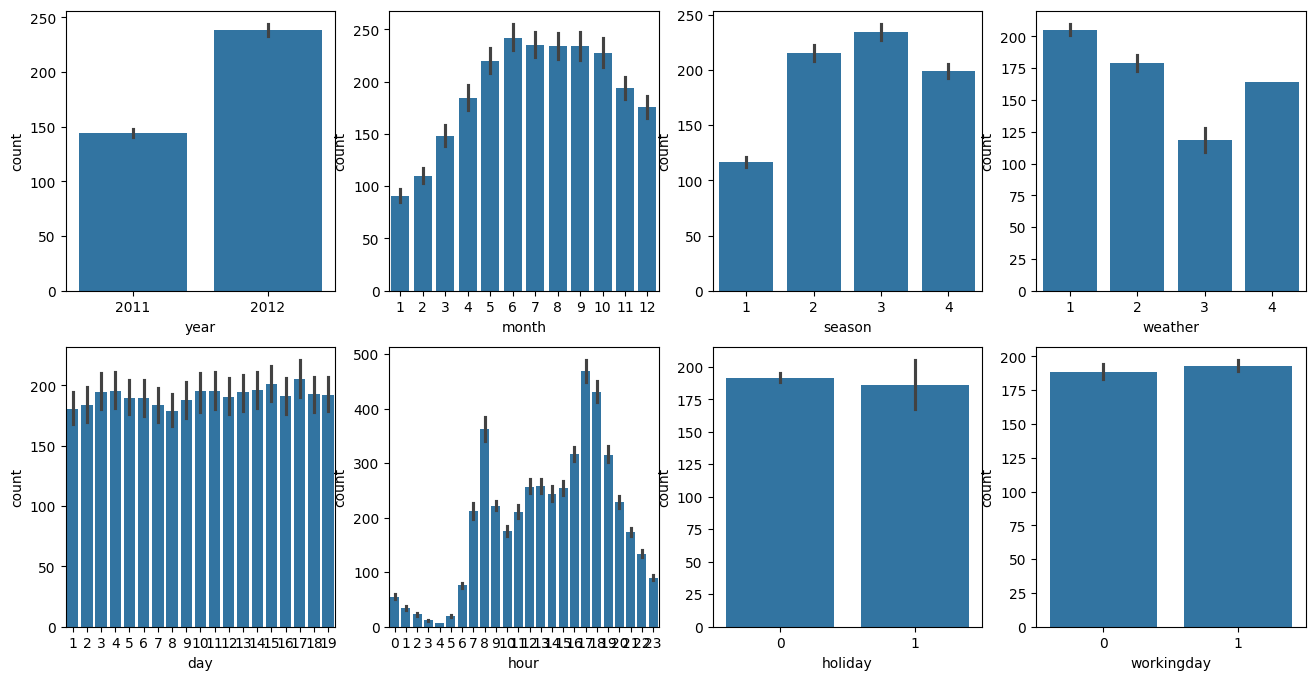

In [26]:
# bike_df에 대해서 탐색. 먼저 시각화.
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
# cat_features에 있는 모든 컬럼별로 개별 컬럼값에 따른 count 의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4) # 몫. i가 4까지는 0이되고, i가 5부터8까지는 1이됨
    col = i%4 # 나머지. 0,1,2,3
    # 사본의 barplot 을 이용해 컬럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])


# 워싱턴 D.C의 자료이기때문에 워싱턴 D.C의 날씨를 확인해봐야함..
# 워싱턴 D.C는 우리나라와 비슷한 날씨,계절..
# month를 보면.. 1~6 까지 점점 늘어나다가 초여름에 가장 많다가,
# 여름에는 초여름 만큼 많지 않다가 가을 겨울이 되면서 점점 줄어듦
# 근데 계절에 대한 부분이 봄여름가을겨울인지 정확한 확인 필요..
# 그리고 count 단위가 달라서 확인 필요.
# 데이터분석할때 합리적으로 이해하기 어려운 데이터들이 많이 있을수 있는데 그것들을 잘 들여다 볼 필요가 있음
# 예를 들어 holiday, workingday 가 0, 1 count가 비슷.. 이런것들은 사실 더 자세히 보는것이 무언가가 나올 가능성이 큼

In [49]:
grouped_counts = bike_df.groupby(['season', 'month'])['count'].mean().reset_index()
grouped_counts
# season -> season 에 해당하는 month의 평균

,season,month,count
0,1,1,90.366516
1,1,2,110.003330
2,1,3,148.169811
3,2,4,184.160616
4,2,5,219.459430
5,2,6,242.031798
6,3,7,235.325658
7,3,8,234.118421
8,3,9,233.805281
9,4,10,227.699232


In [25]:
bike_df[bike_df.season==1].value_counts()

season  holiday  workingday  weather  temp   atemp   humidity  windspeed  count  year  month  day  hour
1       0        0           1        3.28   3.790   53        16.9979    26     2012  2      12   8       1
                 1           1        18.04  21.970  67        8.9981     174    2012  1      12   21      1
                                                     72        6.0032     117    2012  3      15   6       1
                                                                          381    2012  3      15   7       1
                                                               8.9981     188    2012  1      12   15      1
                                                                                                          ..
                                      5.74   6.820   54        12.9980    12     2012  1      3    5       1
                                                     59        12.9980    38     2011  1      10   21      1
                        

In [24]:
bike_df.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# log 값 변환 시 NaN등의 이슈로 log()가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2 # 직접 계산.
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y, pred)
    print("RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}".format(rmsle_val, rmse_val, mae_val))

#### 로그 변환, 피쳐 인코딩, 모델 학습/예측 평가

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [39]:
def get_top_error_data(y_data, pred, n_tops =5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

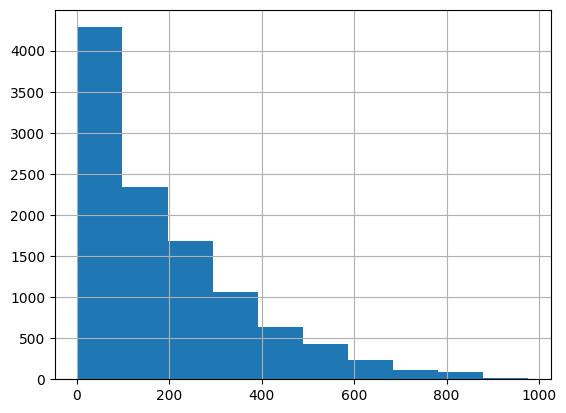

In [40]:
y_target.hist()

<Axes: >

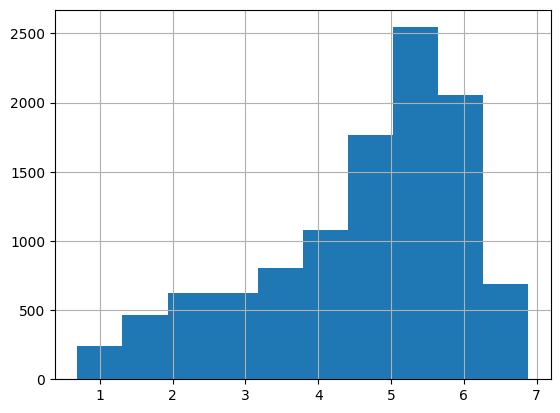

In [41]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [44]:
# 타깃 컬럼인 count 값을 log1p로 로그변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log 를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmp1으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)
# 사용자 매개변수에 로그변환한걸 넣어서.. rmsle 는 그냥 쓰면 되는데
# 사용자함수에 로그 변환한것을 넣었으니,그게 아니라서.. 환원해서 다시 계산.
# rmse에 루트안씌우면 rmsle.

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


In [45]:
# RMSLE: 1.165, RMSE: 140.900, MAE: 105.924 // RMSE 기준으로는 줄어드는것을 볼 수 있음.

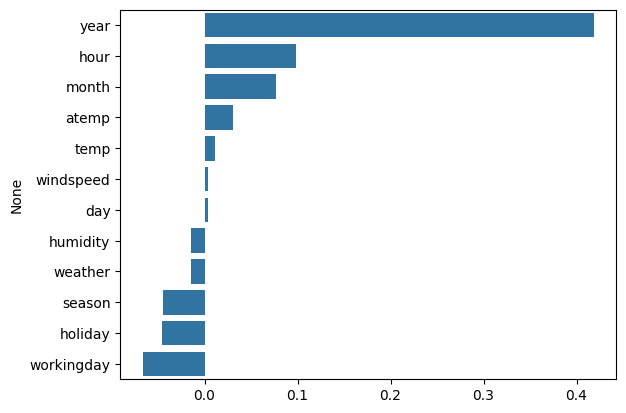

In [55]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')
# 년도(year)가 범주이지, 숫자로 보게되면 안됨.
# 여기에선 숫자로 쓰이게 되어서(1000단위의 큰수) 그래프상으로 크게 보이는 것.
# x 값에 2011,2012 가 들어가게되면.. 숫자가 커서 민감하게 반응하게되어서 범주형으로 바꿔야함.
# month 같은 경우도 12월이 1월의 12배 이런것이 아니라 범주형으로 바꿔야함
# 이것을 인코딩을 통해서 바꾸던지 해야함

In [56]:
# 'year', 'month', 'day', 'hour' 등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns = ['year', 'month', 'day', 'hour', 'holiday',
                                                       'workingday', 'season', 'weather'])

In [59]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: ylabel='None'>

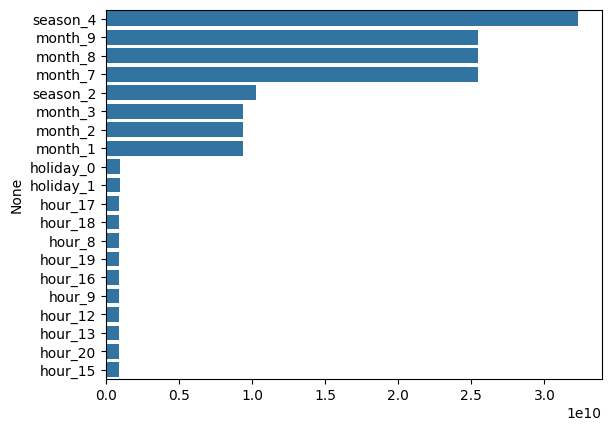

In [61]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [65]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gb_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgb_reg = LGBMRegressor(n_estimators=500, verbose=-1)

# pandas의 DataFrame과 Series 객체는 높은 수준의 데이터 구조를 제공하며, 데이터 분석과 조작을 용이하게 해주지만,
# XGBoost와 같은 일부 머신러닝 라이브러리에서는 이러한 고수준 데이터 구조를 직접적으로 지원하지 않거나, 버전에 따라
# 호환성 문제가 나타날 수 있다.
models = [rf_reg, gb_reg, xgb_reg, lgb_reg]
for i in models:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    # get_model_predict(i, X_train, X_test, y_train, y_test, is_expm1=True)
    get_model_predict(i, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.353, RMSE: 50.114, MAE: 30.995
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.348, MAE: 32.748
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
